In [1]:
# %pip install wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import wandb
wandb.login()

wandb.init(
    project="HPML Final Project",
    entity="HPML-final-team",
    name="Quantization",
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: Currently logged in as: fbg2107 (HPML-final-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
from matplotlib.colors import LogNorm
from os.path import join
import torch.quantization as tq
from torch.quantization import QuantStub, DeQuantStub
import copy
import os
import wandb
from copy import deepcopy
from typing import List, Tuple
import time
import pandas as pd

# set torch random seed for reproducibility
torch.manual_seed(6499)

from google.colab import drive
# drive.mount("/content/drive")

In [4]:
# !ls drive/MyDrive/classes/COMSE6998/

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive.mount("/content/drive")
data_loc = "drive/MyDrive/classes/COMSE6998/"
# data_loc = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(device)

cuda


In [7]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [8]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()

Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



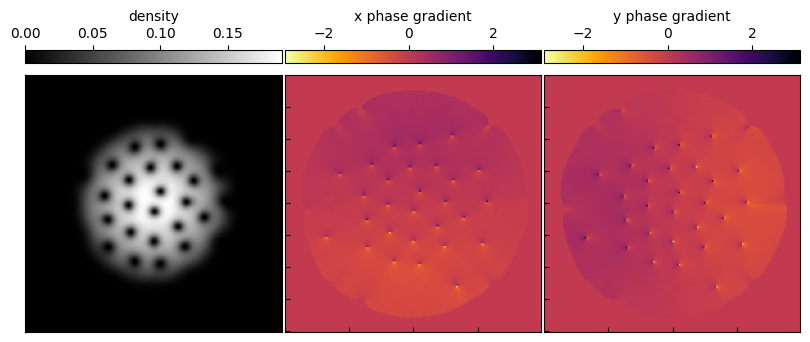

In [9]:
# Visualize an example
idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# Calculate shared vmin and vmax for phase gradients
vmin_phase = np.min(train_data["phase_gradients"][idx, :])
vmax_phase = np.max(train_data["phase_gradients"][idx, :])

im1 = ax[0].imshow(train_data["densities"][idx], cmap="gray", origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04, location="top")
cbar1.set_label("density")
im2 = ax[1].imshow(
    train_data["phase_gradients"][idx, 0],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar2 = fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04, location="top")
cbar2.set_label("x phase gradient")
im3 = ax[2].imshow(
    train_data["phase_gradients"][idx, 1],
    origin="lower",
    cmap="inferno_r",
    vmin=vmin_phase,
    vmax=vmax_phase,
)
cbar3 = fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04, location="top")
cbar3.set_label("y phase gradient")

# remove tick label, but preserve marks
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

plt.savefig(
    os.path.join(data_loc, "./quantized_files/finalPlot_training_set.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

# Custom Datasets/Dataloaders

In [20]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask


train_dataset = BecDataset(
    train_data["densities"], train_data["phase_gradients"], train_data["masks"]
)
val_dataset = BecDataset(
    val_data["densities"], val_data["phase_gradients"], val_data["masks"]
)
test_dataset = BecDataset(
    test_data["densities"], test_data["phase_gradients"], test_data["masks"]
)

# UNET Definition

In [21]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum=0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=0.2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            # print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        # print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        channels,
        bilinear=True,
        add_skip=True,
        out_channels=1,
        wrap_angles=False,
        verbose=False,
    ):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            # Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
                + [Down(channels[-1], channels[-1])]
            )
            self.ups = nn.ModuleList(
                [
                    Up(2 * channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
                + [Up(2 * channels[1], channels[1], bilinear, add_skip)]
            )
        else:
            self.downs = nn.ModuleList(
                [
                    Down(channels[i], channels[i + 1])
                    for i in range(1, len(channels) - 1)
                ]
            )
            self.ups = nn.ModuleList(
                [
                    Up(channels[i + 1], channels[i], bilinear, add_skip)
                    for i in range(len(channels) - 2, 0, -1)
                ]
            )
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        # Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2 * torch.pi
            x = F.relu(x) - torch.pi
        return x

# Training


In [22]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )


def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(val_loader, model, device=device)
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(
            f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}"
        )

In [23]:
def mse_with_mask(outputs, targets, masks, keep_first_dim=False):
    """
    # Custom Loss function
    # Ignores losses for masked out regions (mask = 1), as these are
    # Low density regions and we don't care whether we get them right or not
    """
    if keep_first_dim:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks), dim=(-1, -2, -3))
    else:
        return torch.mean(((outputs - targets) ** 2) * (1 - masks))


# ______
batch_size = 8
epochs = 10

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_dataset, num_workers=2)
test_loader = DataLoader(test_dataset, num_workers=2)

unet = UNet(channels=[1, 8, 16, 32, 64, 128, 256, 512], out_channels=2, verbose=False)

optimizer = optim.Adam(unet.parameters(), lr=1e-3)

train_model(train_loader, unet, mse_with_mask, optimizer, epochs=epochs, device=device)

Epoch 1 Train Loss: 0.015838326904774894, Val Loss: 0.006620944011956453
Epoch 2 Train Loss: 0.005412918757573362, Val Loss: 0.005471170414239168
Epoch 3 Train Loss: 0.00396347755477542, Val Loss: 0.004023841582238674
Epoch 4 Train Loss: 0.0034233248914547617, Val Loss: 0.0032195253297686577
Epoch 5 Train Loss: 0.0029937546970027072, Val Loss: 0.0028650627937167883
Epoch 6 Train Loss: 0.0027315113905979883, Val Loss: 0.0032275081612169743
Epoch 7 Train Loss: 0.0025138052038124036, Val Loss: 0.002946241991594434
Epoch 8 Train Loss: 0.0022653310969915417, Val Loss: 0.002410128014162183
Epoch 9 Train Loss: 0.0020800104229858826, Val Loss: 0.0023931870236992836
Epoch 10 Train Loss: 0.0020058496230621896, Val Loss: 0.002227923832833767


In [24]:
inputs, predictions, truths, masks = predict(test_loader, unet, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)
total_error_orig = errors.mean().item()
print(f"Test MSE: {errors.mean().item()}")

Test MSE: 0.0021860157139599323


Text(0, 0.5, 'Count (log scale)')

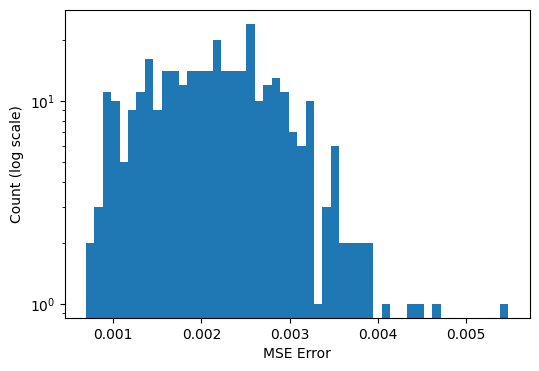

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.hist(errors.cpu().numpy(), bins=50, log=True)
ax.set_xlabel("MSE Error")
ax.set_ylabel("Count (log scale)")

In [26]:
torch.save(unet.state_dict(), os.path.join(data_loc,"unet_original.pth"))

#### Now that we have the original model trained and save, we can have different quantized versions of it.

Note, quantization, in the scope of this study, is focused on
- saving disk space, allowing deployment of smaller models
- testing the quantization effects and how well the unet holds up
- and CPU portability
hence, the model is not necessarily benchmarked for faster infernce, since that would require more extensive optimizations and hardware specific tuning.



### the general workflow is as follows:

- Step 1: Quantize models (weights stay as float32 in memory for inference)
- Step 2: Save models properly (convert to int8 for storage)
- Step 3: Measure file sizes (see compression benefits)
- Step 4: Load models back (int8 → float32 for inference)
- Step 5: Test accuracy (compare predictions)



__Step 1: Quantize Models__

In [27]:
# def quantize_unet_per_tensor(model):
#     """Quantize using one scale per tensor"""
#     model = deepcopy(model).cpu().eval()
#     for module in model.modules():
#         if isinstance(module, nn.Conv2d):
#             w = module.weight.data
#             scale = w.abs().max() / 127.0
#             if scale > 0:
#                 w_q = torch.round(w / scale).clamp(-128, 127)
#                 module.weight.data = w_q * scale
#             if module.bias is not None:
#                 b = module.bias.data
#                 b_scale = b.abs().max() / 127.0
#                 if b_scale > 0:
#                     b_q = torch.round(b / b_scale).clamp(-128, 127)
#                     module.bias.data = b_q * b_scale
#     return model


def quantize_unet_global_per_tensor(model):
    """
    global per-tensor quantization
    - ONE scale factor for entire model
    - Most aggressive quantization
    - Use only for comparison/testing

    Args:
        model: PyTorch model to quantize

    Returns:
        quantized model (all operations on CPU)
    """
    model = deepcopy(model).cpu().eval()

    # find global min/max across ALL weights
    all_weights = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            all_weights.append(module.weight.data.flatten())

    all_weights = torch.cat(all_weights)
    global_min = all_weights.min()
    global_max = all_weights.max()

    # use SINGLE global scale
    global_scale = (global_max - global_min) / 255.0
    global_zero_point = -global_min / global_scale

    quantized_params = 0

    # quantize with shared scale
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            w = module.weight.data

            # quantize to 0-255 range using global scale
            w_q = torch.round(w / global_scale + global_zero_point).clamp(0, 255)

            # dequantize
            module.weight.data = (w_q - global_zero_point) * global_scale
            quantized_params += w.numel()

            if module.bias is not None:
                b = module.bias.data
                b_q = torch.round(b / global_scale + global_zero_point).clamp(0, 255)
                module.bias.data = (b_q - global_zero_point) * global_scale
                quantized_params += b.numel()

    return model


def quantize_unet_per_channel(model, bits=8):
    """
    quantize using one scale per channel
    """
    model = deepcopy(model).cpu().eval()
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            weight = module.weight.data
            scales = []
            quantized_weights = []
            for c in range(weight.shape[0]):
                channel_weight = weight[c]
                scale = channel_weight.abs().max() / (2 ** (bits - 1) - 1)
                scale = max(scale, 1e-8)
                w_q = torch.round(channel_weight / scale).clamp(
                    -(2 ** (bits - 1)), 2 ** (bits - 1) - 1
                )
                scales.append(scale)
                quantized_weights.append(w_q)
            quantized_weights = torch.stack(quantized_weights, dim=0)
            scales = torch.tensor(scales).view(-1, 1, 1, 1)
            module.weight.data = quantized_weights * scales

            if module.bias is not None:
                bias = module.bias.data
                bias_scale = bias.abs().max() / (2 ** (bits - 1) - 1)
                bias_scale = max(bias_scale, 1e-8)
                bias_q = torch.round(bias / bias_scale).clamp(
                    -(2 ** (bits - 1)), 2 ** (bits - 1) - 1
                )
                module.bias.data = bias_q * bias_scale
    return model


# def quantize_unet_mixed_precision(model):
#     """
#     quantize middle layers, keep first/last in float32
#     """
#     model = deepcopy(model).cpu().eval()
#     conv_modules = [
#         (name, module)
#         for name, module in model.named_modules()
#         if isinstance(module, nn.Conv2d)
#     ]
#     skip_first, skip_last = 2, 2

#     for idx, (name, module) in enumerate(conv_modules):
#         if idx < skip_first or idx >= len(conv_modules) - skip_last:
#             continue  # Keep in float32

#         weight = module.weight.data
#         scales = []
#         quantized_weights = []
#         for c in range(weight.shape[0]):
#             channel_weight = weight[c]
#             scale = channel_weight.abs().max() / 127.0
#             scale = max(scale, 1e-8)
#             w_q = torch.round(channel_weight / scale).clamp(-128, 127)
#             scales.append(scale)
#             quantized_weights.append(w_q)

#         quantized_weights = torch.stack(quantized_weights, dim=0)
#         scales = torch.tensor(scales).view(-1, 1, 1, 1)
#         module.weight.data = quantized_weights * scales

#         if module.bias is not None:
#             bias = module.bias.data
#             bias_scale = bias.abs().max() / 127.0
#             bias_scale = max(bias_scale, 1e-8)
#             bias_q = torch.round(bias / bias_scale).clamp(-128, 127)
#             module.bias.data = bias_q * bias_scale

#     return model


def quantize_unet_mixed_precision(model):
    """
    Mixed Precision Quantization (BEST ACCURACY)
    - Keeps critical layers (first and last) in float32
    - Quantizes middle layers to int8 per-layer
    - Best accuracy with some compression

    Args:
        model: PyTorch UNet model to quantize

    Returns:
        Quantized model (all operations on CPU)
    """
    model = deepcopy(model).cpu().eval()

    # Get all conv layers
    conv_modules = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_modules.append((name, module))

    print(f"  Found {len(conv_modules)} Conv2d layers")

    # Keep first 2 and last 2 layers in float32
    skip_first = 2
    skip_last = 2

    quantized_params = 0
    float32_params = 0

    for idx, (name, module) in enumerate(conv_modules):
        weight = module.weight.data

        # Skip first and last layers (keep in float32)
        if idx < skip_first or idx >= len(conv_modules) - skip_last:
            print(f"    Keeping {name} in float32")
            float32_params += weight.numel()
            if module.bias is not None:
                float32_params += module.bias.numel()
            continue

        # Quantize this layer (per-layer, not per-channel)
        scale = weight.abs().max() / 127.0

        if scale > 1e-8:
            w_q = torch.round(weight / scale).clamp(-128, 127)
            module.weight.data = w_q * scale
            quantized_params += weight.numel()

        # Quantize bias
        if module.bias is not None:
            bias = module.bias.data
            bias_scale = bias.abs().max() / 127.0
            bias_scale = max(bias_scale, 1e-8)
            bias_q = torch.round(bias / bias_scale).clamp(-128, 127)
            module.bias.data = bias_q * bias_scale
            quantized_params += bias.numel()

    return model


__STEP 2: SAVE MODELS AS INT8__

These functions convert float32 quantized weights → int8 for storage



In [28]:
def save_quantized_model_per_tensor(model, filepath):
    """Save per-tensor quantized model as int8"""
    state_dict = model.state_dict()
    quantized_state = {}

    for name, param in state_dict.items():
        if param.dtype == torch.float32 and ("weight" in name or "bias" in name):
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                param_int8 = torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                quantized_state[name] = param_int8
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        else:
            quantized_state[name] = param

    torch.save(quantized_state, filepath)


def save_quantized_model_per_channel(model, filepath):
    """
    save per-channel quantized model as int8
    """
    state_dict = model.state_dict()
    quantized_state = {}

    for name, param in state_dict.items():
        if "weight" in name and param.dim() == 4:  # Conv2d weights
            out_channels = param.shape[0]
            scales = []
            quantized_channels = []

            for c in range(out_channels):
                channel = param[c]
                scale = channel.abs().max().item() / 127.0
                scale = max(scale, 1e-8)
                q_channel = torch.round(channel / scale).clamp(-128, 127).to(torch.int8)
                scales.append(scale)
                quantized_channels.append(q_channel)

            quantized_state[name] = torch.stack(quantized_channels, dim=0)
            quantized_state[name + "_scales"] = torch.tensor(scales)

        elif "bias" in name and param.dtype == torch.float32:
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                quantized_state[name] = (
                    torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                )
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        else:
            quantized_state[name] = param

    torch.save(quantized_state, filepath)


# def save_quantized_model_mixed_precision(model, filepath):
#     """
#     save mixed precision model (some int8, some float32)
#     """
#     # for simplicity, just save the state dict as-is
#     # the quantized layers are already dequantized to float32 for inference
#     torch.save(model.state_dict(), filepath)

# def save_quantized_model_mixed_precision(model, filepath):
#     """
#     Save mixed precision model
#     Some layers int8, some float32
#     """
#     state_dict = model.state_dict()
#     quantized_state = {}

#     # Identify which layers were quantized (all except first/last 2)
#     conv_names = []
#     for name, module in model.named_modules():
#         if isinstance(module, nn.Conv2d):
#             conv_names.append(name + '.weight')

#     skip_first = 2
#     skip_last = 2
#     float32_layers = set(conv_names[:skip_first] + conv_names[-skip_last:])

#     for name, param in state_dict.items():
#         # Check if this layer should stay float32
#         base_name = name.replace('.bias', '.weight')

#         if base_name in float32_layers:
#             # Keep float32
#             quantized_state[name] = param
#         elif 'weight' in name and param.dim() == 4:
#             # Quantize per-layer
#             scale = param.abs().max().item() / 127.0
#             if scale > 1e-8:
#                 quantized_state[name] = torch.round(param / scale).clamp(-128, 127).to(torch.int8)
#                 quantized_state[name + '_scale'] = torch.tensor(scale)
#             else:
#                 quantized_state[name] = param
#         elif 'bias' in name and base_name not in float32_layers and param.dtype == torch.float32:
#             # Quantize bias
#             scale = param.abs().max().item() / 127.0
#             if scale > 1e-8:
#                 quantized_state[name] = torch.round(param / scale).clamp(-128, 127).to(torch.int8)
#                 quantized_state[name + '_scale'] = torch.tensor(scale)
#             else:
#                 quantized_state[name] = param
#         else:
#             quantized_state[name] = param

#     torch.save(quantized_state, filepath)


def save_quantized_model_mixed_precision(model, filepath):
    """
    Save mixed precision model
    Some layers int8, some float32
    """
    state_dict = model.state_dict()
    quantized_state = {}

    # Identify which layers were quantized (all except first/last 2)
    conv_names = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_names.append(name + ".weight")

    skip_first = 2
    skip_last = 2
    float32_layers = set(conv_names[:skip_first] + conv_names[-skip_last:])

    for name, param in state_dict.items():
        # Check if this layer should stay float32
        base_name = name.replace(".bias", ".weight")

        if base_name in float32_layers:
            # Keep float32
            quantized_state[name] = param
        elif "weight" in name and param.dim() == 4:
            # Quantize per-layer
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                quantized_state[name] = (
                    torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                )
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        elif (
            "bias" in name
            and base_name not in float32_layers
            and param.dtype == torch.float32
        ):
            # Quantize bias
            scale = param.abs().max().item() / 127.0
            if scale > 1e-8:
                quantized_state[name] = (
                    torch.round(param / scale).clamp(-128, 127).to(torch.int8)
                )
                quantized_state[name + "_scale"] = torch.tensor(scale)
            else:
                quantized_state[name] = param
        else:
            quantized_state[name] = param

    torch.save(quantized_state, filepath)

__step 3: Save Quantized Models and Measure File Sizes__


In [29]:
def load_quantized_model(
    filepath, model_class, load_type="per_channel", **model_kwargs
):
    """Load quantized model and dequantize int8 → float32"""
    state_dict = torch.load(filepath, map_location="cpu")
    dequantized_state = {}

    for name, param in state_dict.items():
        if name.endswith("_scales") or name.endswith("_scale"):
            continue  # Skip scale parameters

        if param.dtype == torch.int8:
            if load_type == "per_channel" and name + "_scales" in state_dict:
                # Per-channel dequantization
                scales = state_dict[name + "_scales"]
                out_channels = param.shape[0]
                dequantized_channels = []
                for c in range(out_channels):
                    dequantized_channels.append(param[c].float() * scales[c])
                dequantized_state[name] = torch.stack(dequantized_channels, dim=0)
            elif name + "_scale" in state_dict:
                # Per-tensor dequantization
                scale = state_dict[name + "_scale"].item()
                dequantized_state[name] = param.float() * scale
            else:
                dequantized_state[name] = param.float()
        else:
            dequantized_state[name] = param

    # create model and load
    model = model_class(**model_kwargs)
    model.load_state_dict(dequantized_state)
    return model


# prepare
test_loader_cpu = DataLoader(test_dataset, batch_size=1, num_workers=2)

# Get original predictions once
print("computing original model predictions...")
with torch.no_grad():
    unet_cpu = deepcopy(unet).cpu().eval()
    _, preds_orig, truths_orig, masks_orig = predict(
        test_loader_cpu, unet_cpu, device="cpu"
    )
    orig_error = mse_with_mask(
        preds_orig, truths_orig, masks_orig, keep_first_dim=True
    ).mean()
    del unet_cpu

methods = {
    "Per-Tensor": (
        quantize_unet_global_per_tensor,
        save_quantized_model_per_tensor,
        "per_tensor",
    ),
    "Per-Channel": (
        quantize_unet_per_channel,
        save_quantized_model_per_channel,
        "per_channel",
    ),
    "Mixed Precision": (
        quantize_unet_mixed_precision,
        save_quantized_model_mixed_precision,
        "mixed",
    ),
}

results = {}

for method_name, (quantize_fn, save_fn, load_type) in methods.items():
    print(f"processing: {method_name}")

    # do the actual quantization
    print(f"[1/5] quantizing model...")
    if method_name == "per-Channel":
        quantized_model = quantize_fn(unet, bits=8)
    else:
        quantized_model = quantize_fn(unet)

    # save as int8
    filename = os.path.join(data_loc, f"./quantized_files/unet_{method_name.lower().replace(' ', '_').replace('-', '_')}.pth")
    print(f"[2/5] saving to {filename}...")
    save_fn(quantized_model, filename)

    # measure file size
    file_size = os.path.getsize(filename) / (1024 * 1024)
    print(f"[3/5] file size: {file_size:.2f} MB")

    # already in memory
    loaded_model = load_quantized_model(
        filename,
        UNet,
        load_type=load_type,
        channels=[1, 8, 16, 32, 64, 128, 256, 512],
        out_channels=2,
    )

    print(f"testing accuracy...")
    with torch.no_grad():
        _, preds_q, truths_q, masks_q = predict(
            test_loader_cpu, quantized_model, device="cpu"
        )

    error_q = mse_with_mask(preds_q, truths_q, masks_q, keep_first_dim=True).mean()
    error_increase = ((error_q / orig_error) - 1) * 100
    diff = torch.abs(preds_orig - preds_q)

    results[method_name] = {
        "file_size": file_size,
        "error": error_q.item(),
        "error_increase(%)": error_increase.item(),
        "mean_diff": diff.mean().item(),
        "max_diff": diff.max().item(),
    }

    print(f"[5/5] Error: {error_q:.8f} (↑{error_increase:.1f}%)")
    print(f"mean diff: {diff.mean():.6f}, Max diff: {diff.max():.6f}")
    print(f"{'-'*10}")

    # Keep the saved file for now (we'll compare sizes)

# save and measure original
torch.save(unet.state_dict(), os.path.join(data_loc, "./quantized_files/unet_original.pth"))
orig_size = os.path.getsize(os.path.join(data_loc, "./quantized_files/unet_original.pth")) / (1024 * 1024)

# Add original model statistics to results
results["Original"] = {
    "file_size": orig_size,
    "error": orig_error.item(),
    "error_increase(%)": 0.0,
    "mean_diff": 0.0,
    "max_diff": 0.0,
}

computing original model predictions...
processing: Per-Tensor
[1/5] quantizing model...
[2/5] saving to drive/MyDrive/classes/COMSE6998/./quantized_files/unet_per_tensor.pth...
[3/5] file size: 16.65 MB
testing accuracy...
[5/5] Error: 0.00291758 (↑33.5%)
mean diff: 0.038339, Max diff: 0.933781
----------
processing: Per-Channel
[1/5] quantizing model...
[2/5] saving to drive/MyDrive/classes/COMSE6998/./quantized_files/unet_per_channel.pth...
[3/5] file size: 16.67 MB
testing accuracy...
[5/5] Error: 0.00258269 (↑18.1%)
mean diff: 0.050083, Max diff: 1.079907
----------
processing: Mixed Precision
[1/5] quantizing model...
  Found 31 Conv2d layers
    Keeping inc.double_conv.0 in float32
    Keeping inc.double_conv.3 in float32
    Keeping ups.6.conv.double_conv.3 in float32
    Keeping outc.conv in float32
[2/5] saving to drive/MyDrive/classes/COMSE6998/./quantized_files/unet_mixed_precision.pth...
[3/5] file size: 16.65 MB
testing accuracy...
[5/5] Error: 0.00220894 (↑1.0%)
mean dif

In [30]:
# create DataFrame
df = pd.DataFrame(results).T
df["compression (multiplier)"] = orig_size / df["file_size"]

# Reorder columns for better readability
df = df[
    [
        "file_size",
        "compression (multiplier)",
        "error",
        "error_increase(%)",
        "mean_diff",
        "max_diff",
    ]
]

In [31]:
df.to_csv(os.path.join(data_loc, "quantization_results.csv"))
df

,file_size,compression (multiplier),error,error_increase(%),mean_diff,max_diff
Per-Tensor,16.647220,3.974165,0.002918,33.465420,0.038339,0.933781
Per-Channel,16.669683,3.968810,0.002583,18.145775,0.050083,1.079907
Mixed Precision,16.654363,3.972461,0.002209,1.048422,0.009804,0.134167
Original,66.158801,1.000000,0.002186,0.000000,0.000000,0.000000


In [32]:
table = wandb.Table(dataframe=df)
wandb.log({"quantization_results_table": table})

In [33]:
def extract_all_weights(model, layer_type="conv"):
    """
    Extract weights from all Conv2d or Linear layers
    Returns: dict with layer names and their weights
    """
    weights_dict = {}

    for name, module in model.named_modules():
        if layer_type == "conv" and isinstance(module, nn.Conv2d):
            weights_dict[name] = module.weight.data.cpu().flatten().numpy()
            if module.bias is not None:
                weights_dict[name + ".bias"] = module.bias.data.cpu().flatten().numpy()
        elif layer_type == "linear" and isinstance(module, nn.Linear):
            weights_dict[name] = module.weight.data.cpu().flatten().numpy()
            if module.bias is not None:
                weights_dict[name + ".bias"] = module.bias.data.cpu().flatten().numpy()

    return weights_dict

In [34]:
quantized_models = {
    "Per-Tensor": quantize_unet_global_per_tensor(unet),
    "Per-Channel": quantize_unet_per_channel(unet, bits=8),
    "Mixed Precision": quantize_unet_mixed_precision(unet),
}

  Found 31 Conv2d layers
    Keeping inc.double_conv.0 in float32
    Keeping inc.double_conv.3 in float32
    Keeping ups.6.conv.double_conv.3 in float32
    Keeping outc.conv in float32


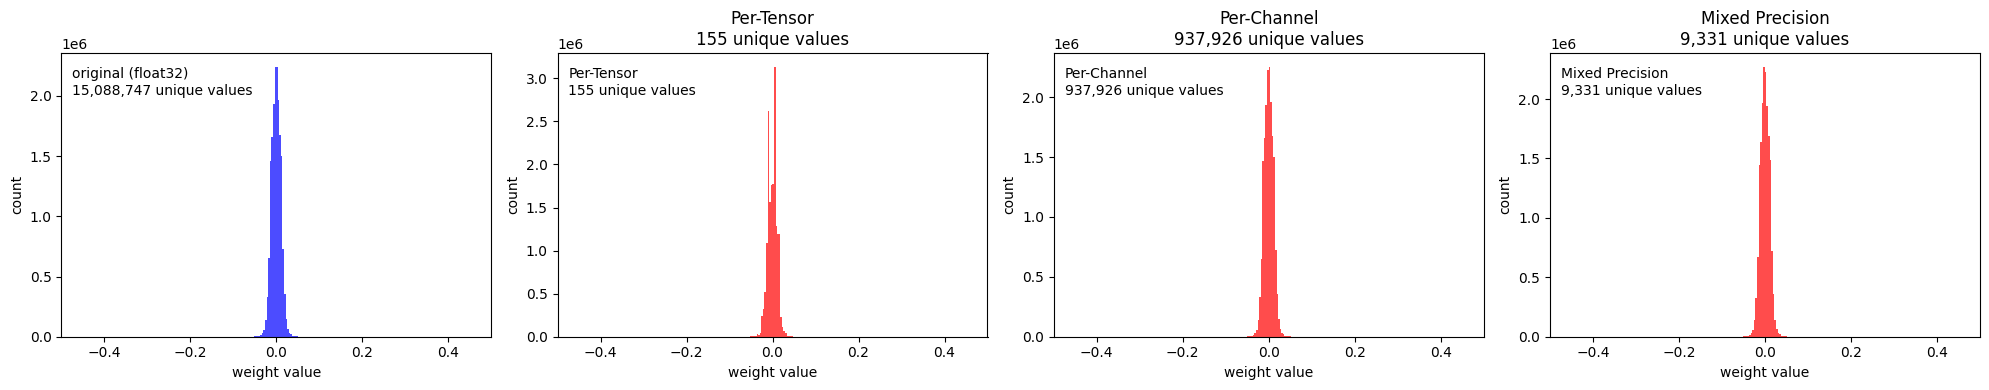

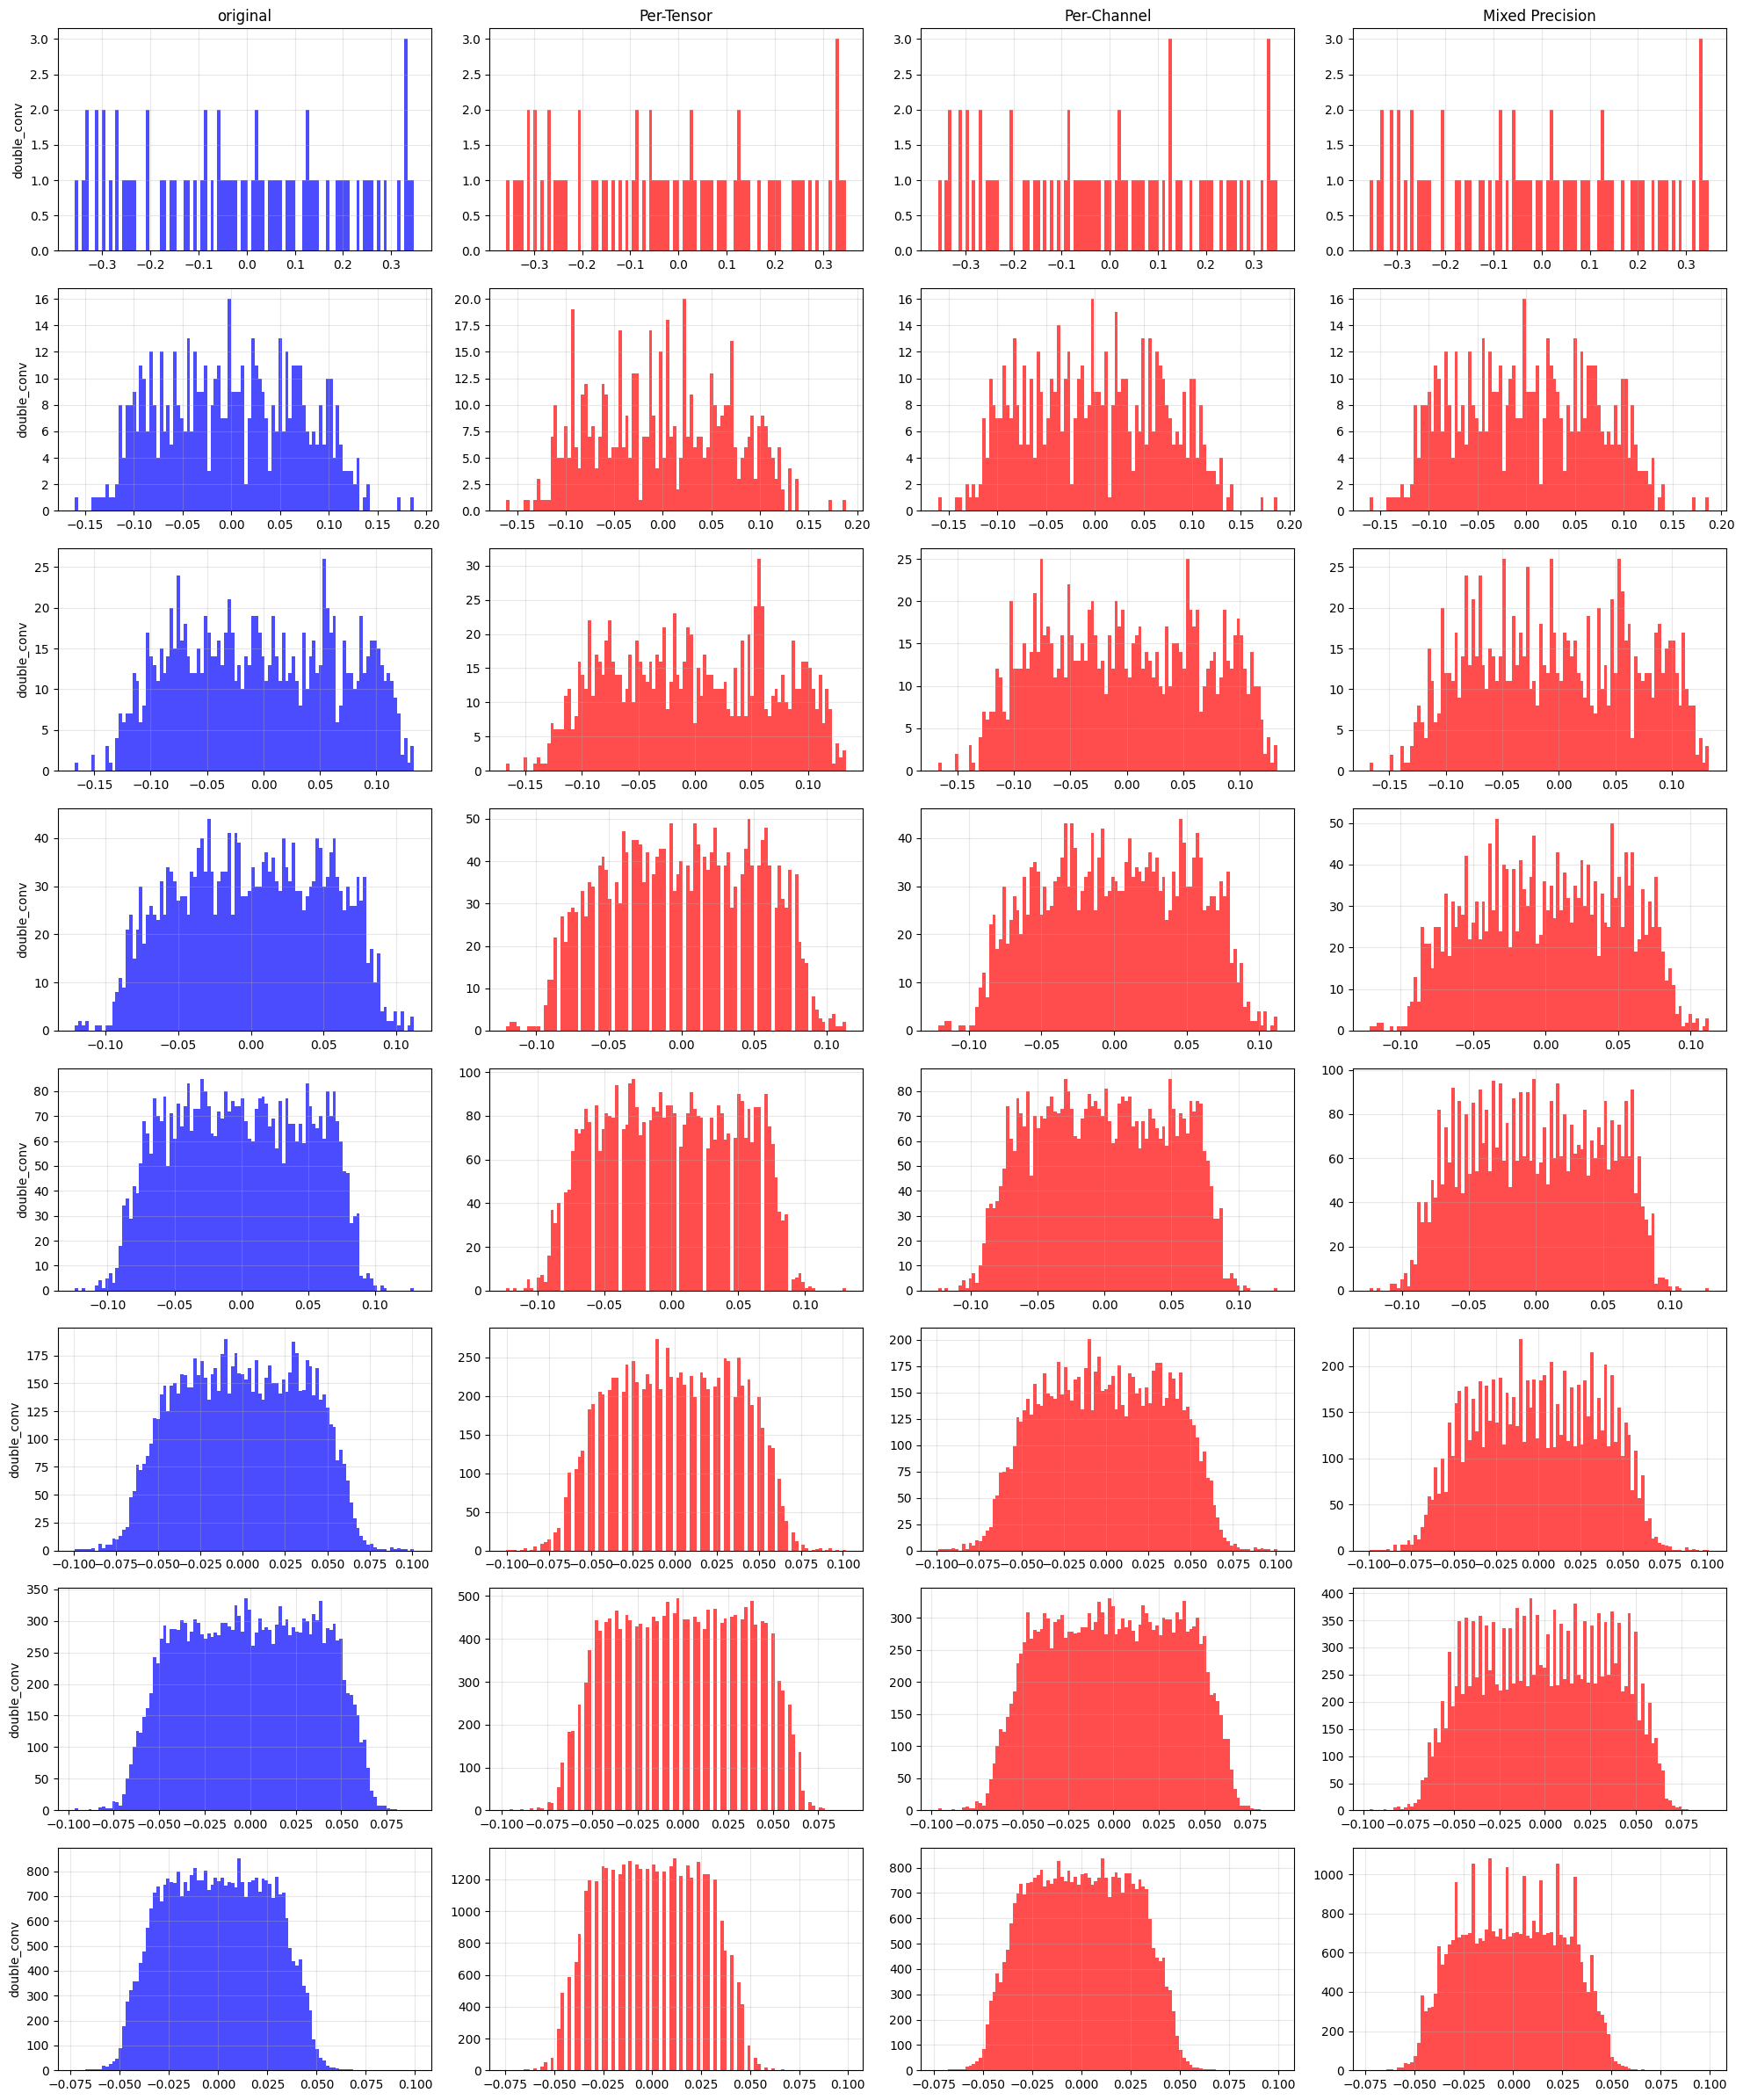

In [35]:
def plot_weight_histograms(
    original_model, quantized_models_dict, save_prefix="weight_comparison"
):
    """
    plot weight histograms for original and quantized models
    """
    # extract weights
    orig_weights = extract_all_weights(original_model)

    quant_weights = {}
    for method_name, model in quantized_models_dict.items():
        quant_weights[method_name] = extract_all_weights(model)

    # 1. overall distribution comparison
    fig, ax = plt.subplots(
        1,
        len(quantized_models_dict) + 1,
        figsize=(5 * (len(quantized_models_dict) + 1), 4),
    )
    if len(quantized_models_dict) == 0:
        ax = [ax]

    # original
    all_orig = np.concatenate([w for w in orig_weights.values()])
    ax[0].hist(all_orig, bins=200, alpha=0.7, color="blue", edgecolor="none")

    ax[0].text(
        0.025,
        0.95,
        f"original (float32)\n{len(np.unique(all_orig)):,} unique values",
        transform=ax[0].transAxes,
        ha="left",
        va="top",
    )
    ax[0].set_xlabel("weight value")
    ax[0].set_ylabel("count")

    ax[0].set_xlim(-0.5, 0.5)

    # quantized versions
    for idx, (method_name, weights) in enumerate(quant_weights.items(), 1):
        all_quant = np.concatenate([w for w in weights.values()])
        ax[idx].hist(all_quant, bins=200, alpha=0.7, color="red", edgecolor="none")
        ax[idx].set_title(
            f"{method_name}\n{len(np.unique(all_quant)):,} unique values", fontsize=12
        )
        ax[idx].text(
            0.025,
            0.95,
            f"{method_name}\n{len(np.unique(all_quant)):,} unique values",
            transform=ax[idx].transAxes,
            ha="left",
            va="top",
        )
        ax[idx].set_xlabel("weight value")
        ax[idx].set_ylabel("count")

        ax[idx].set_xlim(-0.5, 0.5)



    plt.tight_layout()
    wandb.log(
    {"overall_distributionx": wandb.Image(fig)},
    step=None
    )
    plt.savefig(f"{save_prefix}_overall_distribution.png", dpi=150, bbox_inches="tight")
    plt.show()

    # 2. per-layer comparison (first 8 layers)
    layer_names = [name for name in orig_weights.keys() if "bias" not in name][:8]
    n_layers = len(layer_names)

    if n_layers > 0:
        fig, ax = plt.subplots(
            n_layers,
            len(quantized_models_dict) + 1,
            figsize=(5 * (len(quantized_models_dict) + 1), 3 * n_layers),
        )

        if n_layers == 1:
            ax = ax.reshape(1, -1)

        for layer_idx, layer_name in enumerate(layer_names):
            # original
            orig_layer = orig_weights[layer_name]
            ax[layer_idx, 0].hist(
                orig_layer, bins=100, alpha=0.7, color="blue", edgecolor="none"
            )

            # extract short layer name for y-axis
            short_name = layer_name.split(".")[-2] if "." in layer_name else layer_name
            ax[layer_idx, 0].set_ylabel(short_name[:15])
            ax[layer_idx, 0].grid(True, alpha=0.3)

            if layer_idx == 0:
                ax[layer_idx, 0].set_title("original", fontsize=12)

            # quantized versions
            for method_idx, (method_name, weights) in enumerate(
                quant_weights.items(), 1
            ):
                if layer_name in weights:
                    quant_layer = weights[layer_name]
                    ax[layer_idx, method_idx].hist(
                        quant_layer, bins=100, alpha=0.7, color="red", edgecolor="none"
                    )
                    ax[layer_idx, method_idx].grid(True, alpha=0.3)

                    if layer_idx == 0:
                        ax[layer_idx, method_idx].set_title(method_name, fontsize=12)

        plt.tight_layout()
        wandb.log(
          {f"unique values per layer": wandb.Image(fig)}, step=None
        )
        plt.savefig(f"{save_prefix}_per_layer.png", dpi=150, bbox_inches="tight")
        plt.show()


plot_weight_histograms(
    unet,
    quantized_models,
    save_prefix=os.path.join(data_loc, "./quantized_files/quantized_figures/unet_weights"),
)

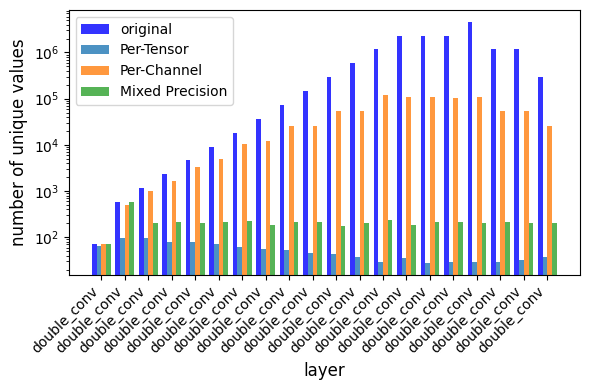

In [36]:
def plot_weight_discretization(
    original_model, quantized_models_dict, save_prefix="weight_comparison"
):
    """
    plot weight discretization (unique values per layer)
    """
    # extract weights
    orig_weights = extract_all_weights(original_model)

    quant_weights = {}
    for method_name, model in quantized_models_dict.items():
        quant_weights[method_name] = extract_all_weights(model)

    # unique values per layer plot
    fig, ax = plt.subplots(figsize=(6, 4))

    layer_names_for_plot = [name for name in orig_weights.keys() if "bias" not in name][
        :20
    ]
    x = np.arange(len(layer_names_for_plot))
    width = 0.8 / (len(quantized_models_dict) + 1)

    # original
    orig_unique = [len(np.unique(orig_weights[name])) for name in layer_names_for_plot]
    ax.bar(
        x - width * len(quantized_models_dict) / 2,
        orig_unique,
        width,
        label="original",
        alpha=0.8,
        color="blue",
    )

    # quantized
    for idx, (method_name, weights) in enumerate(quant_weights.items()):
        quant_unique = [
            len(np.unique(weights[name])) if name in weights else 0
            for name in layer_names_for_plot
        ]
        ax.bar(
            x - width * len(quantized_models_dict) / 2 + width * (idx + 1),
            quant_unique,
            width,
            label=method_name,
            alpha=0.8,
        )

    ax.set_xlabel("layer", fontsize=12)
    ax.set_ylabel("number of unique values", fontsize=12)
    # ax.set_title('weight discretization by layer', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(
        [name.split(".")[-2] if "." in name else name for name in layer_names_for_plot],
        rotation=45,
        ha="right",
    )
    ax.legend()
    # ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale("log")

    plt.tight_layout()
    wandb.log(
        {f"unique values": wandb.Image(fig)}, step=None
    )
    plt.savefig(f"{save_prefix}_unique_values.png", dpi=300, bbox_inches="tight")
    plt.show()


# plot weight discretization by layer
plot_weight_discretization(
    unet,
    quantized_models,
    save_prefix=os.path.join(data_loc, "./quantized_files/quantized_figures/unet_weights"),
)

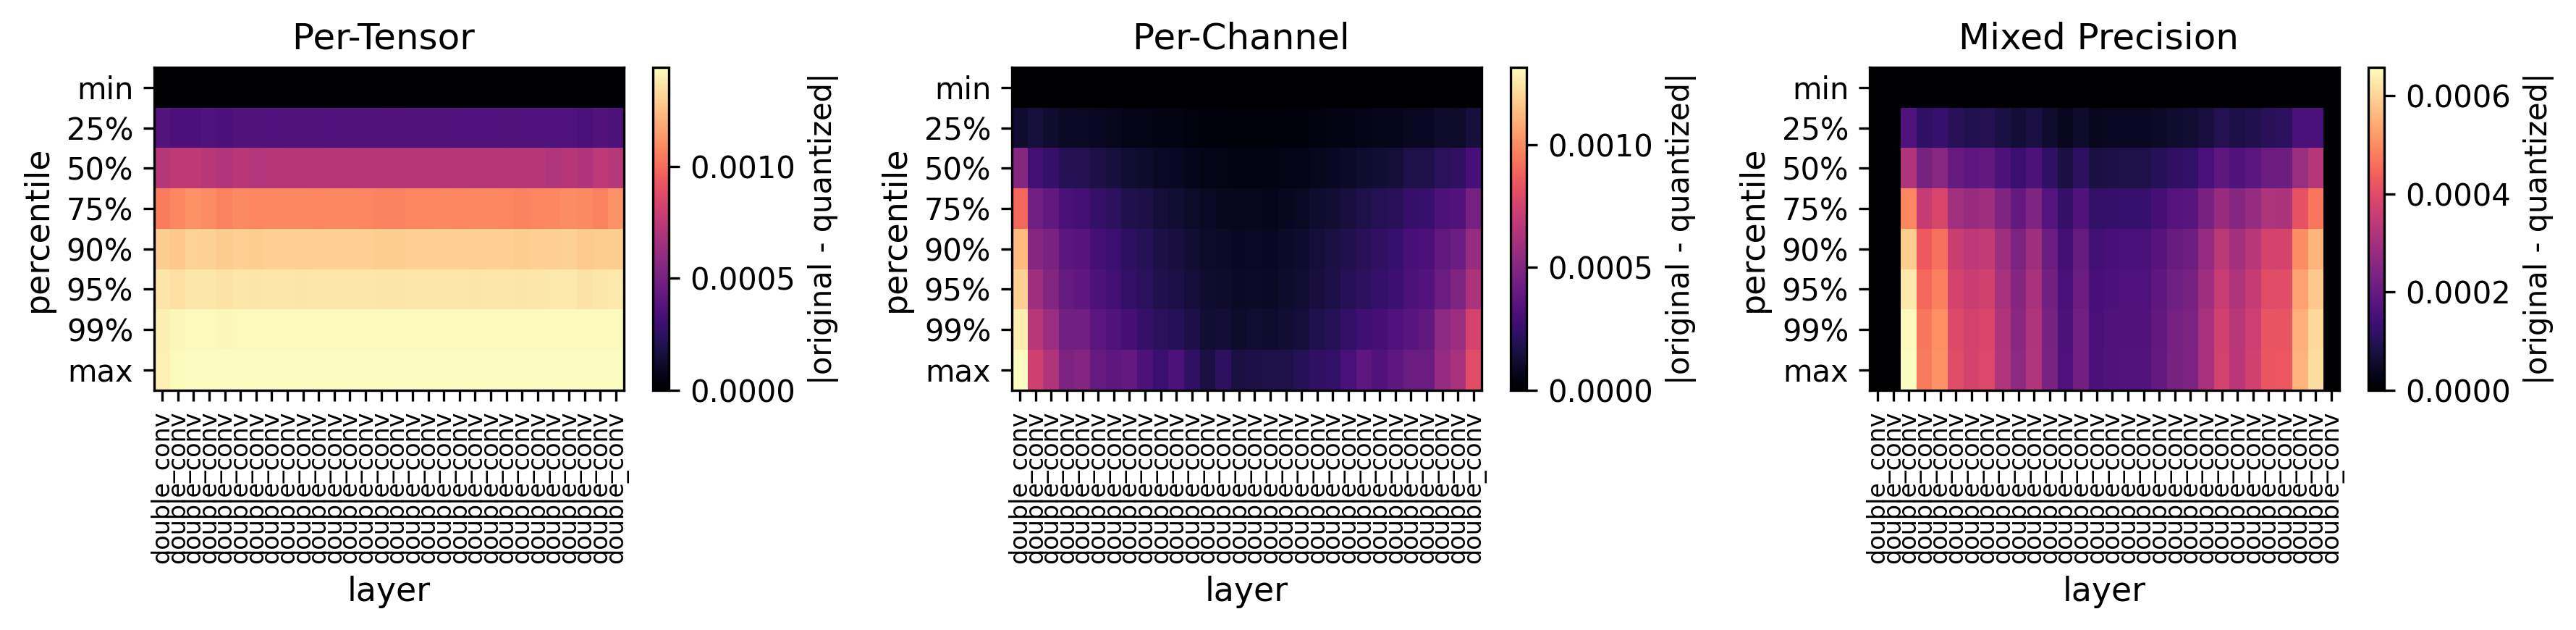

In [37]:
def plot_weight_heatmaps(
    original_model, quantized_models_dict, save_prefix="weight_comparison"
):
    """
    plot weight change heatmaps in a single figure with three panels
    """
    # extract weights
    orig_weights = extract_all_weights(original_model)

    quant_weights = {}
    for method_name, model in quantized_models_dict.items():
        quant_weights[method_name] = extract_all_weights(model)

    # create single figure with subplots
    n_methods = len(quantized_models_dict)
    fig, ax = plt.subplots(1, n_methods, figsize=(12, 3), dpi=300)

    if n_methods == 1:
        ax = [ax]

    # plot heatmap for each method
    for idx, (method_name, weights) in enumerate(quant_weights.items()):
        # calculate differences for each layer
        layer_names_heat = [name for name in orig_weights.keys() if "bias" not in name][
            :30
        ]
        diffs_matrix = []

        for layer_name in layer_names_heat:
            if layer_name in weights:
                orig = orig_weights[layer_name]
                quant = weights[layer_name]

                # compute histogram of differences
                diff = np.abs(orig - quant)
                percentiles = np.percentile(diff, [0, 25, 50, 75, 90, 95, 99, 100])
                diffs_matrix.append(percentiles)
            else:
                diffs_matrix.append([0] * 8)

        diffs_matrix = np.array(diffs_matrix).T

        # plot heatmap
        im = ax[idx].imshow(
            diffs_matrix, aspect="auto", cmap="magma", interpolation="nearest"
        )

        ax[idx].set_yticks(range(8))
        ax[idx].set_yticklabels(
            ["min", "25%", "50%", "75%", "90%", "95%", "99%", "max"]
        )
        ax[idx].set_xticks(range(len(layer_names_heat)))
        ax[idx].set_xticklabels(
            [name.split(".")[-2] if "." in name else name for name in layer_names_heat],
            rotation=90,
            fontsize=8,
        )

        ax[idx].set_title(f"{method_name} ", fontsize=12)
        ax[idx].set_ylabel("percentile", fontsize=11)
        ax[idx].set_xlabel("layer", fontsize=11)

        # add colorbar for each subplot
        plt.colorbar(im, ax=ax[idx], label="|original - quantized|")

    plt.tight_layout()
    wandb.log(
      {"heatmaps": wandb.Image(fig)},step=None
    )
    plt.savefig(f"{save_prefix}_heatmaps.png", dpi=300, bbox_inches="tight")
    plt.show()


# plot weight heatmaps (three panels in one figure)
plot_weight_heatmaps(
    unet,
    quantized_models,
    save_prefix=os.path.join(data_loc, "./quantized_files/quantized_figures/unet_weights"),
)

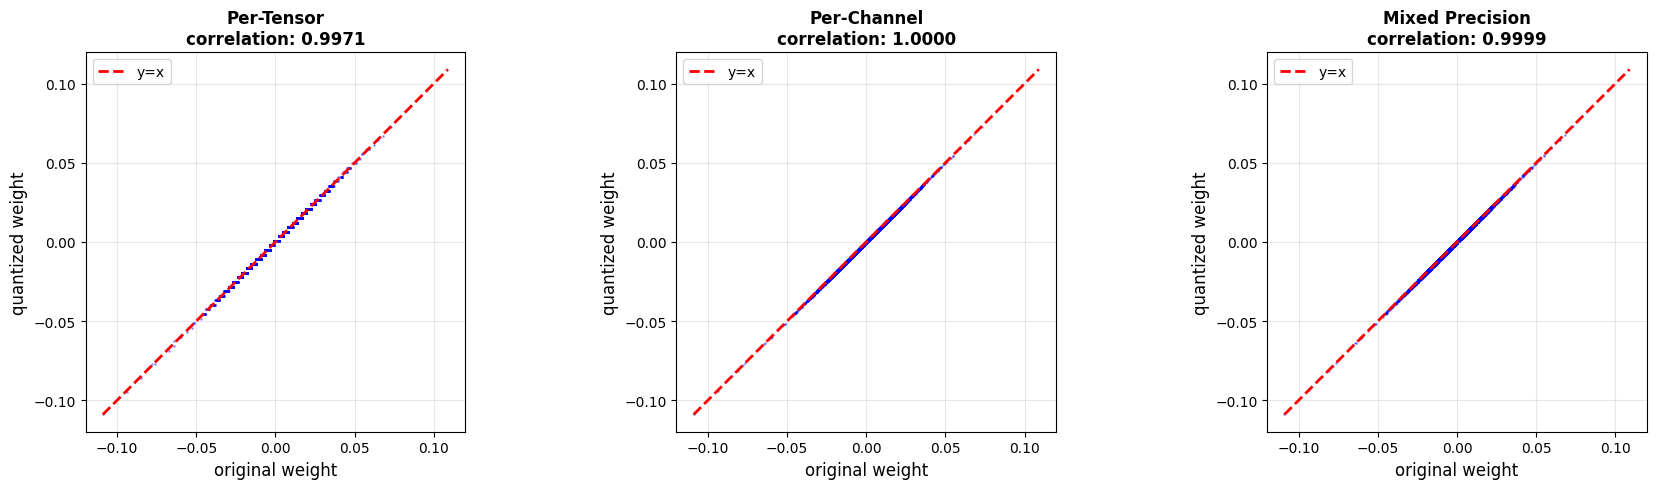

In [38]:
def plot_weight_scatter_comparison(
    original_model,
    quantized_models_dict,
    num_samples=50000,
    save_prefix="weight_scatter",
):
    """
    scatter plot showing original vs quantized weights with y=x line
    """
    orig_weights = extract_all_weights(original_model)
    all_orig = np.concatenate([w for w in orig_weights.values()])

    # sample if too many points
    if len(all_orig) > num_samples:
        indices = np.random.choice(len(all_orig), num_samples, replace=False)
        all_orig_sampled = all_orig[indices]
    else:
        indices = np.arange(len(all_orig))
        all_orig_sampled = all_orig

    n_methods = len(quantized_models_dict)
    fig, ax = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5))

    if n_methods == 1:
        ax = [ax]

    for idx, (method_name, model) in enumerate(quantized_models_dict.items()):
        weights = extract_all_weights(model)
        all_quant = np.concatenate([w for w in weights.values()])
        all_quant_sampled = all_quant[indices]

        # scatter plot
        ax[idx].scatter(all_orig_sampled, all_quant_sampled, alpha=0.3, s=1, c="blue")

        # y=x line
        lim = max(abs(all_orig_sampled).max(), abs(all_quant_sampled).max())
        ax[idx].plot([-lim, lim], [-lim, lim], "r--", linewidth=2, label="y=x")

        # correlation
        corr = np.corrcoef(all_orig_sampled, all_quant_sampled)[0, 1]

        ax[idx].set_xlabel("original weight", fontsize=12)
        ax[idx].set_ylabel("quantized weight", fontsize=12)
        ax[idx].set_title(
            f"{method_name}\ncorrelation: {corr:.4f}", fontsize=12, fontweight="bold"
        )
        ax[idx].grid(True, alpha=0.3)
        ax[idx].legend()
        ax[idx].set_aspect("equal")

    plt.tight_layout()
    wandb.log(
      {"unet_scatter": wandb.Image(fig)},step=None
    )
    plt.savefig(f"{save_prefix}.png", dpi=150, bbox_inches="tight")
    plt.show()


# plot scatter comparisons with y=x line
plot_weight_scatter_comparison(
    unet,
    quantized_models,
    save_prefix=os.path.join(data_loc, "./quantized_files/quantized_figures/unet_scatter"),
)

In [39]:
unet = unet.to(device)

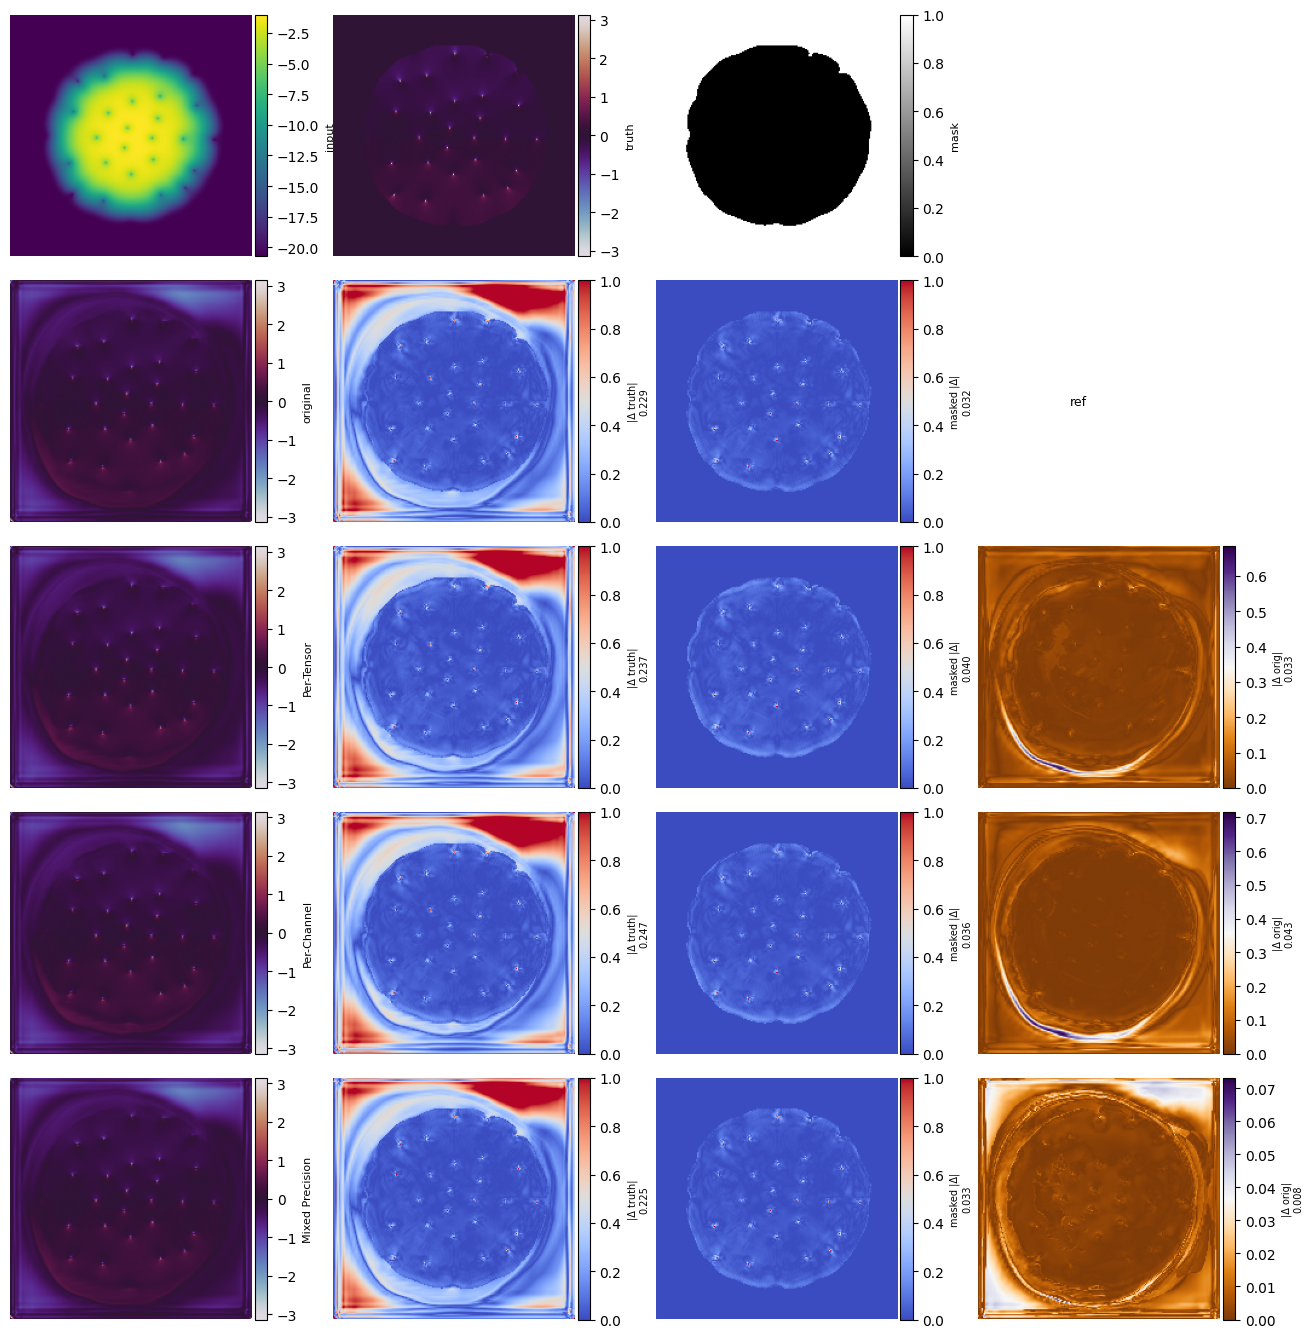

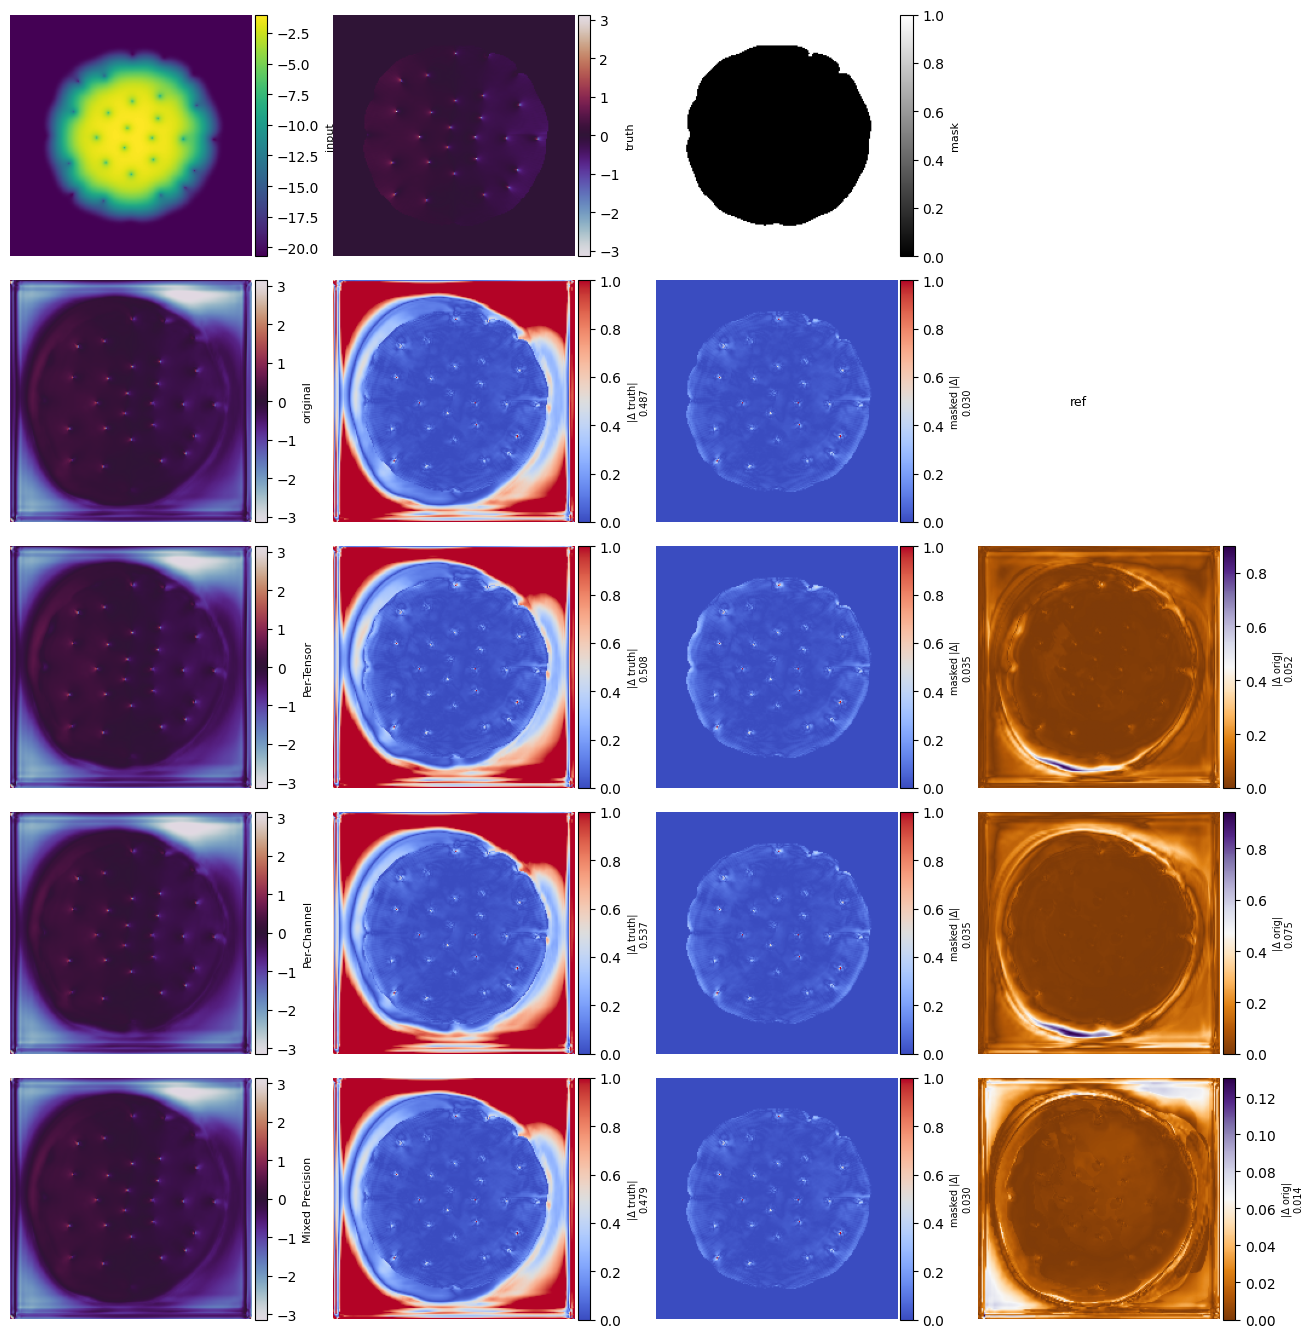

✓ generated 1 prediction comparison plots


In [40]:
def compare_bec_predictions_4methods(
    original_model,
    quantized_models_dict,
    test_loader,
    device="cuda",
    num_samples=1,
    save_prefix="bec_predictions",
):
    """
    compare BEC predictions: ground truth, original, and quantized methods
    """

    original_model.eval()
    for model in quantized_models_dict.values():
        model.eval()

    sample_count = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets, masks) in enumerate(test_loader):
            if sample_count >= num_samples:
                break

            # get predictions from all models
            inputs_device = inputs.to(device)
            inputs_cpu = inputs.cpu()

            # original prediction (on GPU)
            pred_original = original_model(inputs_device).cpu()

            # quantized predictions (on CPU)
            predictions = {"original": pred_original}
            for method_name, model in quantized_models_dict.items():
                predictions[method_name] = model(inputs_cpu)

            # move data to numpy
            input_np = inputs[0].cpu().numpy()
            target_np = targets[0].cpu().numpy()
            mask_np = masks[0].cpu().numpy()

            predictions_np = {
                name: pred[0].cpu().numpy() for name, pred in predictions.items()
            }

            # get number of output channels
            n_channels = target_np.shape[0]

            # create visualization for this sample
            for ch in range(n_channels):
                n_methods = len(predictions)
                fig = plt.figure(figsize=(14, 3 * (n_methods + 1)))

                # wider vertical spacing, less horizontal spacing
                plt.subplots_adjust(wspace=0.01, hspace=0.1, left=0.04, right=0.96, top=0.92, bottom=0.05)

                # row 0: input, ground truth, mask
                ax = plt.subplot(n_methods + 1, 4, 1)
                im = ax.imshow(input_np[0], cmap="viridis")
                ax.axis("off")
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                cbar.set_label('input', fontsize=8)

                ax = plt.subplot(n_methods + 1, 4, 2)
                im = ax.imshow(target_np[ch], cmap="twilight", vmin=-np.pi, vmax=np.pi)
                ax.axis("off")
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                cbar.set_label('truth', fontsize=8)

                ax = plt.subplot(n_methods + 1, 4, 3)
                im = ax.imshow(mask_np[0], cmap="gray", vmin=0, vmax=1)
                ax.axis("off")
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                cbar.set_label('mask', fontsize=8)

                # simple stats in last column
                ax = plt.subplot(n_methods + 1, 4, 4)
                ax.axis("off")
                stats_text = f"sample {sample_count + 1}\nchannel {ch}\n"
                # stats_text += f"mask: {100*mask_np[0].mean():.0f}%"
                # ax.text(0.05, 0.5, stats_text, fontsize=8, verticalalignment="center", family="monospace")

                # rows 1-N: each model's prediction
                for row_idx, (method_name, pred_np) in enumerate(predictions_np.items(), 1):
                    base_col = (row_idx - 1) * 4

                    # prediction
                    ax = plt.subplot(n_methods + 1, 4, base_col + 4 + 1)
                    im = ax.imshow(pred_np[ch], cmap="twilight", vmin=-np.pi, vmax=np.pi)
                    ax.axis("off")
                    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                    cbar.set_label(method_name, fontsize=8)

                    # difference from ground truth
                    ax = plt.subplot(n_methods + 1, 4, base_col + 4 + 2)
                    diff_gt = np.abs(pred_np[ch] - target_np[ch])
                    im = ax.imshow(diff_gt, cmap="coolwarm", vmin=0, vmax=1)
                    ax.axis("off")
                    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                    cbar.set_label(f'|Δ truth|\n{diff_gt.mean():.3f}', fontsize=7)

                    # masked difference
                    ax = plt.subplot(n_methods + 1, 4, base_col + 4 + 3)
                    masked_diff_gt = diff_gt * (1 - mask_np[0])
                    valid_pixels = (1 - mask_np[0]).sum()
                    masked_mean = masked_diff_gt.sum() / valid_pixels if valid_pixels > 0 else 0
                    im = ax.imshow(masked_diff_gt, cmap="coolwarm", vmin=0, vmax=1)
                    ax.axis("off")
                    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                    cbar.set_label(f'masked |Δ|\n{masked_mean:.3f}', fontsize=7)

                    # difference from original (if not original)
                    ax = plt.subplot(n_methods + 1, 4, base_col + 4 + 4)
                    if method_name == "original":
                        ax.text(0.5, 0.5, "ref", ha="center", va="center", fontsize=9)
                        ax.axis("off")
                    else:
                        diff_orig = np.abs(pred_np[ch] - predictions_np["original"][ch])
                        im = ax.imshow(diff_orig, cmap="PuOr", vmin=0)
                        ax.axis("off")
                        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
                        cbar.set_label(f'|Δ orig|\n{diff_orig.mean():.3f}', fontsize=7)

                # plt.suptitle(f"BEC phase prediction - sample {sample_count + 1}, channel {ch}",
                #            fontsize=11, y=0.98)
                wandb.log( {"BEC reconstruction": wandb.Image(fig)},step=None)
                plt.savefig(f"{save_prefix}_sample{sample_count+1}_ch{ch}.png",
                          dpi=150, bbox_inches="tight", pad_inches=0.05)
                plt.show()

            sample_count += 1

    print(f"✓ generated {sample_count} prediction comparison plots")


# run the BEC prediction comparison
compare_bec_predictions_4methods(
    unet,
    quantized_models,
    test_loader,
    device=device,
    num_samples=1,
    save_prefix=os.path.join(data_loc, "./quantized_files/quantized_figures/bec_4methods"),
)

val loss train loss

# Test Set Evaluation

In [41]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet, device=device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim=True)

print(f"Error on the testing set: {errors.mean()}")

Error on the testing set: 0.0021860157139599323


In [42]:
# Convert to numpy arrays
inputs_cpu = inputs.cpu().numpy()
predictions_cpu = predictions.cpu().numpy()
truths_cpu = truths.cpu().numpy()
masks_cpu = masks.cpu().numpy()
errors_cpu = errors.cpu().numpy()

/tmp/ipython-input-2282759515.py:13: RuntimeWarning: invalid value encountered in divide
  residual_x = (truth_x - predicted_x) / truth_x
/tmp/ipython-input-2282759515.py:14: RuntimeWarning: invalid value encountered in divide
  residual_y = (truth_y - predicted_y) / truth_y


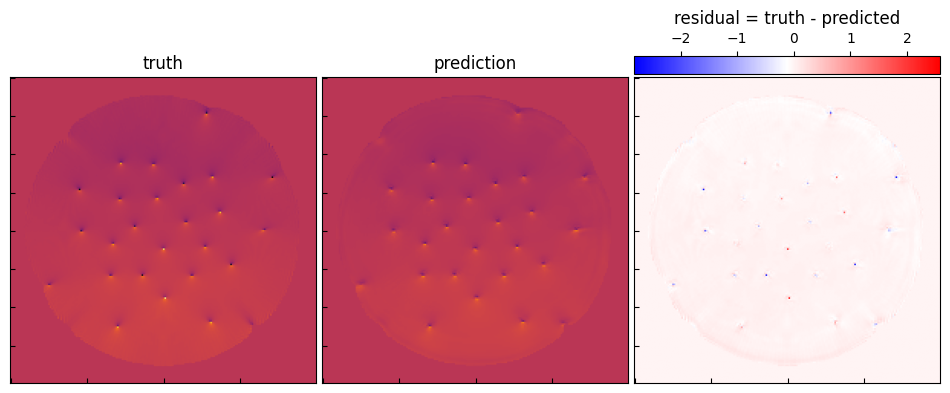

In [43]:
idx = 100
vmin = truths_cpu.min()
vmax = truths_cpu.max()
fig, ax = plt.subplots(1, 3, figsize=(12, 8), dpi=100)
ax = ax.ravel()
plt.subplots_adjust(hspace=0.02, wspace=0.02)
truth_x = truths_cpu[idx, 0]
truth_y = truths_cpu[idx, 1]

predicted_x = predictions_cpu[idx, 0] * (1 - masks_cpu[idx, 0])
predicted_y = predictions_cpu[idx, 1] * (1 - masks_cpu[idx, 1])

residual_x = (truth_x - predicted_x) / truth_x
residual_y = (truth_y - predicted_y) / truth_y

# Only where truth != 0
percentage_error_x = np.zeros_like(truth_x)
mask = truth_x != 0
percentage_error_x[mask] = 100 * (truth_x[mask] - predicted_x[mask]) / truth_x[mask]

residual = truth_x - predicted_x
ax[0].imshow(truth_x, vmin=vmin, vmax=vmax, cmap="inferno")
ax[1].imshow(predicted_x, vmin=vmin, vmax=vmax, cmap="inferno")
# ax[3].imshow(truth_y , vmin = vmin, vmax = vmax)
# ax[4].imshow(predicted_y, vmin = vmin, vmax = vmax)

# show the residual in the 3 column
resim = ax[2].imshow(residual, cmap="bwr")
# ax[5].imshow(residual_y, vmin = -1, vmax = 1, cmap="bwr")
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(direction="in")

# make an inset axis for ax[2]
cbar_inset = ax[2].inset_axes([0, 1.01, 1, 0.06])

# make a colorbar using cbar_inset

cbar = fig.colorbar(resim, cax=cbar_inset, orientation="horizontal")
cbar_inset.set_title(r"residual = truth - predicted")
# put ticks on top of the cbar
cbar_inset.xaxis.set_ticks_position("top")
# fig.colorbar(resim, ax=ax[2], location='top', label='Residual Value', fraction=0.046, pad=0.04)


ax[0].set_title("truth")
ax[1].set_title("prediction")


plt.savefig(
    os.path.join(data_loc, "final_example_residual.png"),
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.1,
)

Text(0, 0.5, 'Frequency')

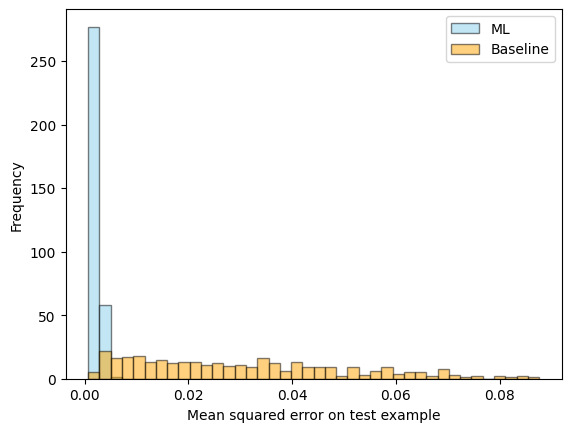

In [44]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths_cpu, axis=(-1, -2, -3))
all_errors = np.concatenate([errors_cpu, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(
    errors_cpu,
    alpha=0.5,
    bins=bin_edges,
    label="ML",
    color="skyblue",
    edgecolor="black",
)
plt.hist(
    baseline_errors,
    alpha=0.5,
    bins=bin_edges,
    label="Baseline",
    color="orange",
    edgecolor="black",
)
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")

In [45]:
wandb.finish()